In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline


import csv
import matplotlib.mlab as mlab
import os
import glob
%matplotlib inline
from scipy.optimize import curve_fit
from scipy import optimize
from scipy.signal import savgol_filter
from readTRC import readTrc
from scipy.fftpack import rfft, irfft, fftfreq
from scipy.stats import chisquare

In [2]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def find_vals(X,Y,cut):
    dataX = X[cut:]
    dataY = Y[cut:]
    minn = min(dataY)
    sig_val = minn*0.5
    MeanLoc = np.where(dataY==minn)[0][0]
    Mean = dataX[MeanLoc]
    L = dataY[0:MeanLoc]
    R = dataY[MeanLoc:len(dataY)]
    LP =find_nearest(L,sig_val)
    RP =find_nearest(R,sig_val)
    whereL = np.where(L==LP)[0][0]
    whereR = np.where(R==RP)[0][0]
    Lpoint = dataX[whereL]
    Rpoint = dataX[MeanLoc+whereR]
    FWHM = (Rpoint-Lpoint)   
    return (Mean,FWHM)

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [3]:
cd /Users/austinmcdonald/Desktop/data/Ion-stuff/Ion mobilitys/Argon/090718-bottel-2bar-FG

/Users/austinmcdonald/Desktop/data/Ion-stuff/Ion mobilitys/Argon/090718-bottel-2bar-FG


In [4]:
#PATH = '/Users/austinmcdonald/Desktop/data/Ion-stuff/Ion mobilitys/Argon/090418-cleaned-2bar/'
files = glob.glob('*.txt')
#files.remove('.DS_Store')
files.sort()
files

['125.txt', '150.txt', '175.txt', '200-dirty.txt', '200.txt']

In [5]:
ml = 1e3
Hold = np.loadtxt('125.txt')
Xhot = moving_average(Hold[0]*ml,100)
Yhot = moving_average(Hold[1]*ml,100)


In [258]:
a=find_nearest(Xhot,450)
meancut = np.where(Xhot==a)[0][0]
sigma = np.std(Yhot[meancut:])

In [259]:
def gaussian(x, height, center, width):
    return height*np.exp(-(x - center)**2/(2*width**2))
def one_gaussians(x, h1, c1, w1):
    return (gaussian(x, h1, c1, w1))

def gauss_fit_vals(X,Y):
    minn = min(Y)
    MeanLoc = np.where(Y==minn)[0][0]
    Mean = X[MeanLoc]
    vals = [minn,Mean,20]
    return vals

def SignalCut(X,Y):
    TriggerTime = find_nearest(Xhot,0)
    Trigger     = np.where(Xhot==TriggerTime)[0][0]
    Cut = Trigger+100
    minPulseHold = find_nearest(Yhot,min(Yhot[2*Cut:]))
    minPulse     = np.where(Yhot==minPulseHold)[0][0]
    SignalCut = Cut + (minPulse-Cut)/2
    return int(SignalCut)

In [260]:
CUT = SignalCut(Xhot,Yhot)
fitval = gauss_fit_vals(Xhot[CUT:],Yhot[CUT:])

errfunc = lambda p, x, y: (one_gaussians(x, *p) - y)**2
optim, success = optimize.leastsq(errfunc, fitval, args=(Xhot[CUT:],Yhot[CUT:]))
optim

array([  -0.34622843,  257.92745244,   39.71646527])

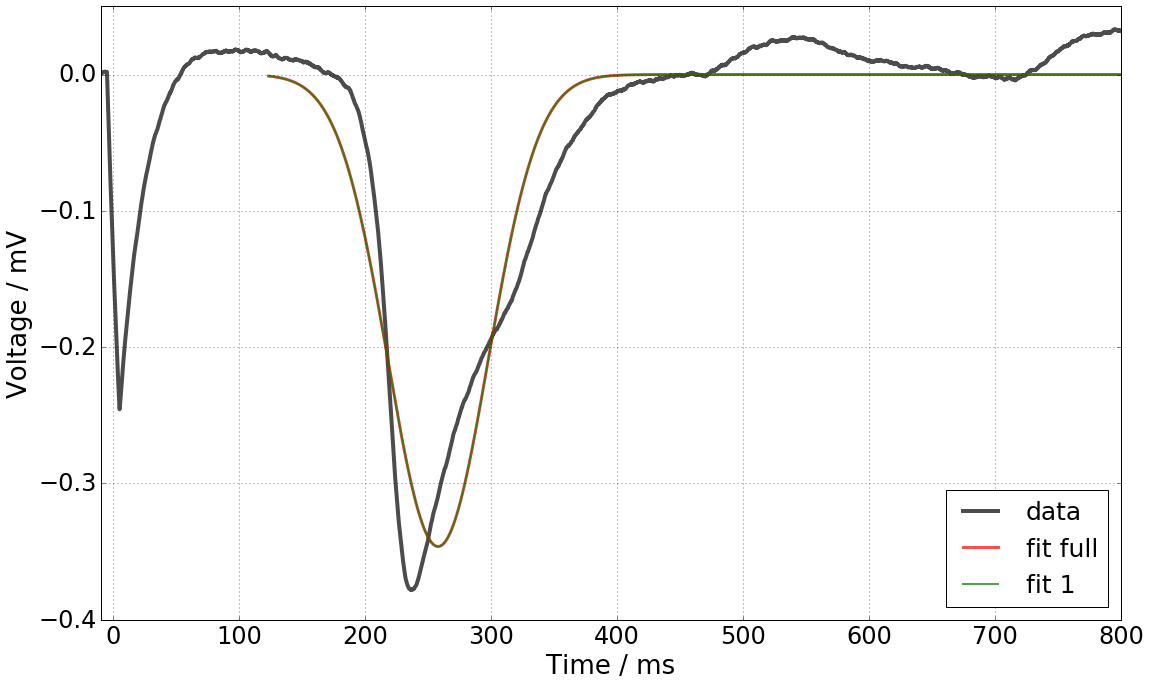

In [212]:
plt.figure(figsize=(15,9))

plt.plot(Xhot,Yhot,color='k',linewidth=4,alpha=0.7,label='data')
plt.plot(Xhot[CUT:],one_gaussians(Xhot[CUT:],*optim),'r',label='fit full',lw=3,alpha=0.7)


y1 = gaussian(Xhot[CUT:],*optim[0:3])
#y2 = gaussian(Xhot[CUT:],*optim[3:6])
plt.plot(Xhot[CUT:],y1,'g',label='fit 1',lw=2,alpha=0.7)
#plt.plot(Xhot[CUT:],y2,'g',label='fit 2',lw=2,alpha=0.7)
plt.xlim(-10,800)
plt.ylim(-0.4,0.05)
plt.grid()
plt.legend(loc='lower right',fontsize=25)
plt.tight_layout()
plt.xlabel(r'Time / ms',fontsize=26)
plt.ylabel('Voltage / mV',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [215]:
chisquare(Yhot[CUT:], f_exp=one_gaussians(Xhot[CUT:],*optim),ddof = dof)

Power_divergenceResult(statistic=-4.2670911989078993e+54, pvalue=1.0)

In [219]:
E = one_gaussians(Xhot[CUT:],*optim)
O = Yhot[CUT:]
dof = len(O)-1-3
chi = np.sum((O-E)**2/sigma**2)/dof
chi      

7.4783856521242766

In [32]:
def gaussian(x, height, center, width):
    return height*np.exp(-(x - center)**2/(2*width**2))

def two_gaussians(x, h1, c1, w1,
                  h2, c2, w2):
    return (gaussian(x, h1, c1, w1) +
            gaussian(x, h2, c2, w2) )

def gauss_fit_vals(X,Y):
    minn = min(Y)
    MeanLoc = np.where(Y==minn)[0][0]
    Mean = X[MeanLoc]
    vals = [minn,Mean,20,minn*.6,Mean+100,20]
    return vals

def SignalCut(X,Y):
    TriggerTime = find_nearest(Xhot,0)
    Trigger     = np.where(Xhot==TriggerTime)[0][0]
    Cut = Trigger+100
    minPulseHold = find_nearest(Yhot,min(Yhot[2*Cut:]))
    minPulse     = np.where(Yhot==minPulseHold)[0][0]
    SignalCut = Cut + (minPulse-Cut)/2
    return int(SignalCut)

In [33]:
CUT = SignalCut(Xhot,Yhot)
fitval = gauss_fit_vals(Xhot[CUT:],Yhot[CUT:])

errfunc = lambda p, x, y: (two_gaussians(x, *p) - y)**2
optim, success = optimize.leastsq(errfunc, fitval, args=(Xhot[CUT:],Yhot[CUT:]))
optim

array([ -2.66347102e-01,   2.36638051e+02,   1.75062033e+01,
        -2.20259434e-01,   2.85347244e+02,   4.20934441e+01])

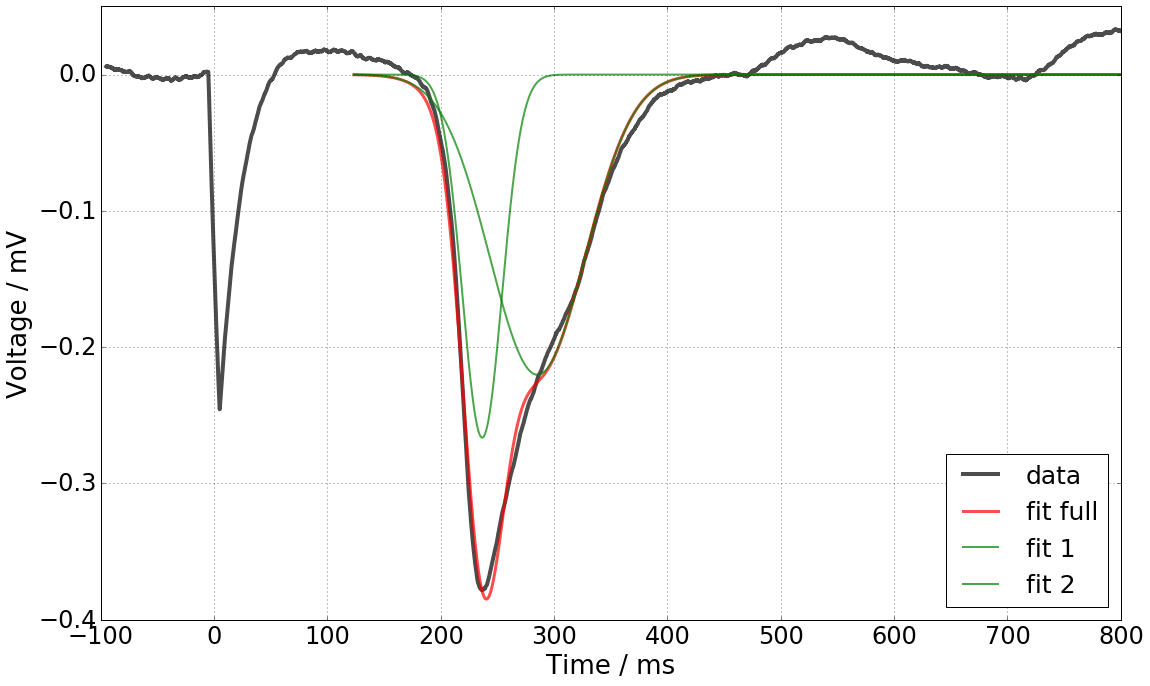

In [34]:
plt.figure(figsize=(15,9))

plt.plot(Xhot,Yhot,color='k',linewidth=4,alpha=0.7,label='data')
plt.plot(Xhot[CUT:],two_gaussians(Xhot[CUT:],*optim),'r',label='fit full',lw=3,alpha=0.7)


y1 = gaussian(Xhot[CUT:],*optim[0:3])
y2 = gaussian(Xhot[CUT:],*optim[3:6])
plt.plot(Xhot[CUT:],y1,'g',label='fit 1',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y2,'g',label='fit 2',lw=2,alpha=0.7)
plt.xlim(-100,800)
plt.ylim(-0.4,0.05)
plt.grid()
plt.legend(loc='lower right',fontsize=25)
plt.tight_layout()
plt.xlabel(r'Time / ms',fontsize=26)
plt.ylabel('Voltage / mV',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [55]:
chisquare(Yhot[CUT:], f_exp=two_gaussians(Xhot[CUT:],*optim))

Power_divergenceResult(statistic=-3.705675494393763e+44, pvalue=1.0)

In [36]:
E = two_gaussians(Xhot[CUT:],*optim)
O = Yhot[CUT:]
dof = len(O)-1-6
chi = np.sum((O-E)**2/sigma**2)/dof
chi      

1.8966583690800682

In [37]:
def three_gaussians(x, h1, c1, w1,
                     h2, c2, w2,
                     h3, c3, w3):
    return (gaussian(x, h1, c1, w1) +
            gaussian(x, h2, c2, w2) +
            gaussian(x, h3, c3, w3))

def gauss_fit_vals_3(X,Y):
    minn = min(Y)
    MeanLoc = np.where(Y==minn)[0][0]
    Mean = X[MeanLoc]
    g1 = [minn,Mean,20]
    g2 = [minn*.6,Mean+100,20]
    g3 = [minn*.3,Mean+150,20]
    vals = g1+g2+g3
    return vals

def SignalCut(X,Y):
    TriggerTime = find_nearest(Xhot,0)
    Trigger     = np.where(Xhot==TriggerTime)[0][0]
    Cut = Trigger+100
    minPulseHold = find_nearest(Yhot,min(Yhot[2*Cut:]))
    minPulse     = np.where(Yhot==minPulseHold)[0][0]
    SignalCut = Cut + (minPulse-Cut)/2
    return SignalCut


CUT = SignalCut(Xhot,Yhot)
fitval = gauss_fit_vals_3(Xhot[CUT:],Yhot[CUT:])

errfunc = lambda p, x, y: (three_gaussians(x, *p) - y)**2
optim, success = optimize.leastsq(errfunc, fitval, args=(Xhot[CUT:],Yhot[CUT:]))
optim

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:29: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:32: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


array([ -1.67918236e-01,   2.31126788e+02,   1.29954983e+01,
        -1.97559111e-01,   2.48503076e+02,   2.40460697e+01,
        -1.72218498e-01,   2.99021685e+02,  -4.05110719e+01])

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:12: DeprecationWarning:

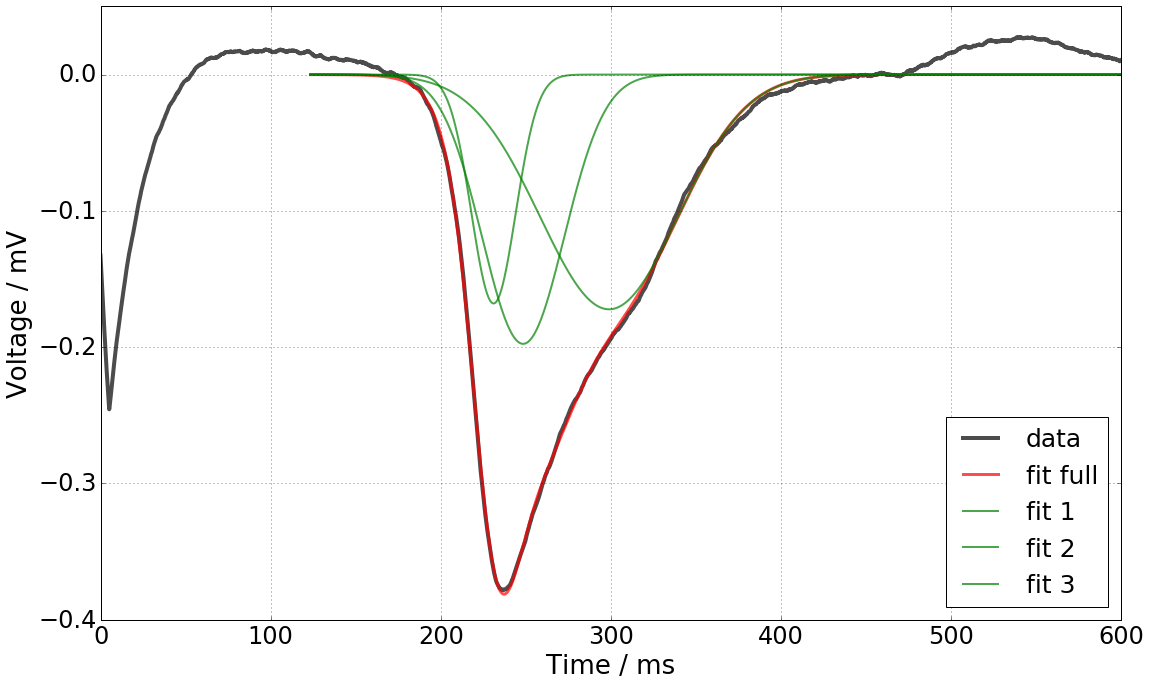

In [38]:
plt.figure(figsize=(15,9))

plt.plot(Xhot,Yhot,color='k',linewidth=4,alpha=0.7,label='data')
plt.plot(Xhot[CUT:],three_gaussians(Xhot[CUT:],*optim),'r',label='fit full',lw=3,alpha=0.7)


y1 = gaussian(Xhot[CUT:],*optim[0:3])
y2 = gaussian(Xhot[CUT:],*optim[3:6])
y3 = gaussian(Xhot[CUT:],*optim[6:9])

plt.plot(Xhot[CUT:],y1,'g',label='fit 1',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y2,'g',label='fit 2',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y3,'g',label='fit 3',lw=2,alpha=0.7)


plt.xlim(0,600)
plt.ylim(-0.4,0.05)
plt.grid()
plt.legend(loc='lower right',fontsize=25)
plt.tight_layout()
plt.xlabel(r'Time / ms',fontsize=26)
plt.ylabel('Voltage / mV',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [42]:
E = three_gaussians(Xhot[CUT:],*optim)
O = Yhot[CUT:]
dof = len(O)-1-9
chi = np.sum((O-E)**2/sigma**2)/dof
chi      

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


1.6806811800271213

In [43]:
def four_gaussians(x, h1, c1, w1,
                      h2, c2, w2,
                      h3, c3, w3,
                      h4, c4, w4 ):
    return (gaussian(x, h1, c1, w1) +
            gaussian(x, h2, c2, w2) +
            gaussian(x, h3, c3, w3) +
            gaussian(x, h4, c4, w4) ) 

def gauss_fit_vals_4(X,Y):
    minn = min(Y)
    MeanLoc = np.where(Y==minn)[0][0]
    Mean = X[MeanLoc]
    g1 = [minn,Mean,20]
    g2 = [minn*.6,Mean+50,20]
    g3 = [minn*.3,Mean+75,20]
    g4 = [minn*.2,Mean+100,20]
    vals = g1+g2+g3+g4
    return vals

def SignalCut(X,Y):
    TriggerTime = find_nearest(Xhot,0)
    Trigger     = np.where(Xhot==TriggerTime)[0][0]
    Cut = Trigger+100
    minPulseHold = find_nearest(Yhot,min(Yhot[2*Cut:]))
    minPulse     = np.where(Yhot==minPulseHold)[0][0]
    SignalCut = Cut + (minPulse-Cut)/2
    return SignalCut


CUT = SignalCut(Xhot,Yhot)
fitval = gauss_fit_vals_4(Xhot[CUT:],Yhot[CUT:])

errfunc = lambda p, x, y: (four_gaussians(x, *p) - y)**2
optim, success = optimize.leastsq(errfunc, fitval, args=(Xhot[CUT:],Yhot[CUT:]))
optim

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:32: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:35: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


array([ -1.26584405e-01,   2.30081904e+02,   1.13867359e+01,
        -2.57282054e-01,   2.44834849e+02,   2.30639113e+01,
        -2.62994692e-02,   3.58220627e+02,   3.11183625e+01,
        -1.77597232e-01,   2.97747285e+02,   3.26568172e+01])

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:12: DeprecationWarning:

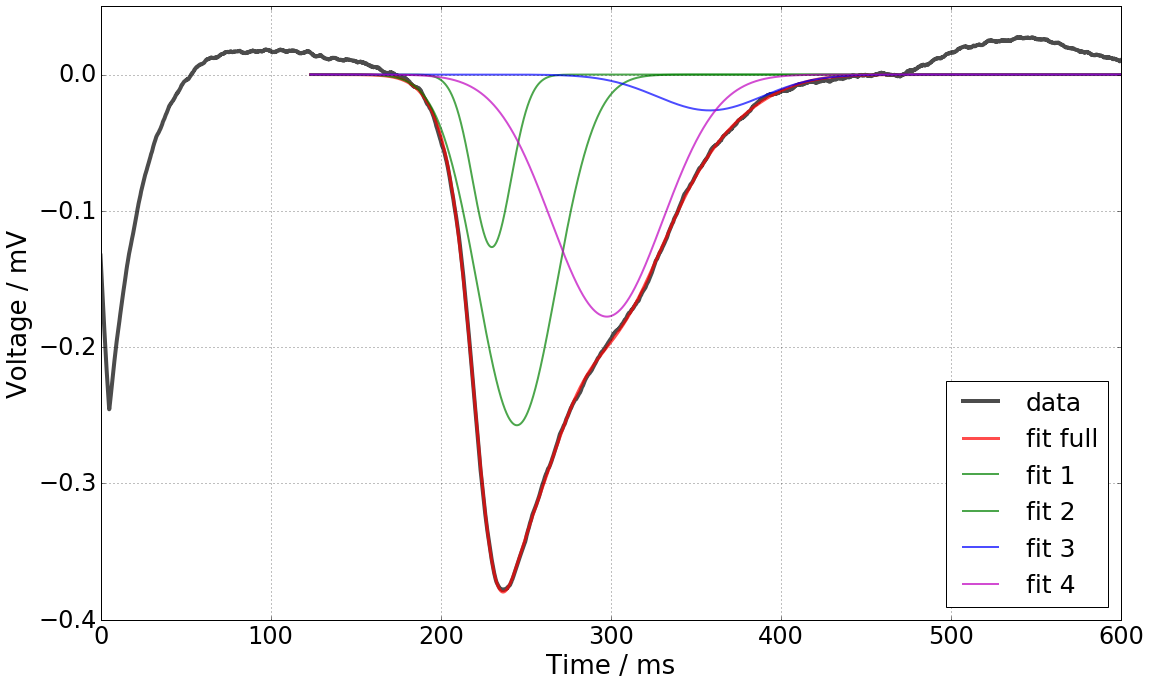

In [44]:
plt.figure(figsize=(15,9))

plt.plot(Xhot,Yhot,color='k',linewidth=4,alpha=0.7,label='data')
plt.plot(Xhot[CUT:],four_gaussians(Xhot[CUT:],*optim),'r',label='fit full',lw=3,alpha=0.7)


y1 = gaussian(Xhot[CUT:],*optim[0:3])
y2 = gaussian(Xhot[CUT:],*optim[3:6])
y3 = gaussian(Xhot[CUT:],*optim[6:9])
y4 = gaussian(Xhot[CUT:],*optim[9:12])

plt.plot(Xhot[CUT:],y1,'g',label='fit 1',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y2,'g',label='fit 2',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y3,'b',label='fit 3',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y4,'m',label='fit 4',lw=2,alpha=0.7)


plt.xlim(0,600)
plt.ylim(-0.4,0.05)
plt.grid()
plt.legend(loc='lower right',fontsize=25)
plt.tight_layout()
plt.xlabel(r'Time / ms',fontsize=26)
plt.ylabel('Voltage / mV',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [46]:
E = four_gaussians(Xhot[CUT:],*optim)
O = Yhot[CUT:]
dof = len(O)-1-12
chi = np.sum((O-E)**2/sigma**2)/dof
chi      

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


1.6597098977065612

In [64]:
def five_gaussians(x, h1, c1, w1,
                      h2, c2, w2,
                      h3, c3, w3,
                      h4, c4, w4, 
                      h5, c5, w5):
    return (gaussian(x, h1, c1, w1) +
            gaussian(x, h2, c2, w2) +
            gaussian(x, h3, c3, w3) +
            gaussian(x, h4, c4, w4) +
            gaussian(x, h5, c5, w5)) 

def gauss_fit_vals_5(X,Y):
    minn = min(Y)
    MeanLoc = np.where(Y==minn)[0][0]
    Mean = X[MeanLoc]
    g1 = [minn,Mean,20]
    g2 = [minn*.6,Mean+50,20]
    g3 = [minn*.3,Mean+75,20]
    g4 = [minn*.2,Mean+100,20]
    g5 = [minn*.1,Mean+125,20]
    vals = g1+g2+g3+g4+g5
    return vals

def SignalCut(X,Y):
    TriggerTime = find_nearest(Xhot,0)
    Trigger     = np.where(Xhot==TriggerTime)[0][0]
    Cut = Trigger+100
    minPulseHold = find_nearest(Yhot,min(Yhot[2*Cut:]))
    minPulse     = np.where(Yhot==minPulseHold)[0][0]
    SignalCut = Cut + (minPulse-Cut)/2
    return SignalCut


CUT = SignalCut(Xhot,Yhot)
fitval = gauss_fit_vals_5(Xhot[CUT:],Yhot[CUT:])

errfunc = lambda p, x, y: (five_gaussians(x, *p) - y)**2
optim, success = optimize.leastsq(errfunc, fitval, args=(Xhot[CUT:],Yhot[CUT:]))
optim

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:35: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:38: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


array([ -6.74468647e-02,   2.29766176e+02,   9.04948645e+00,
        -2.77572645e-01,   2.36711800e+02,   1.92101706e+01,
        -1.56154144e-01,   3.07060110e+02,   2.80636865e+01,
        -1.39154395e-01,   2.67586660e+02,   2.04847569e+01,
        -2.76215229e-02,   3.62093885e+02,   2.90318659e+01])

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning:

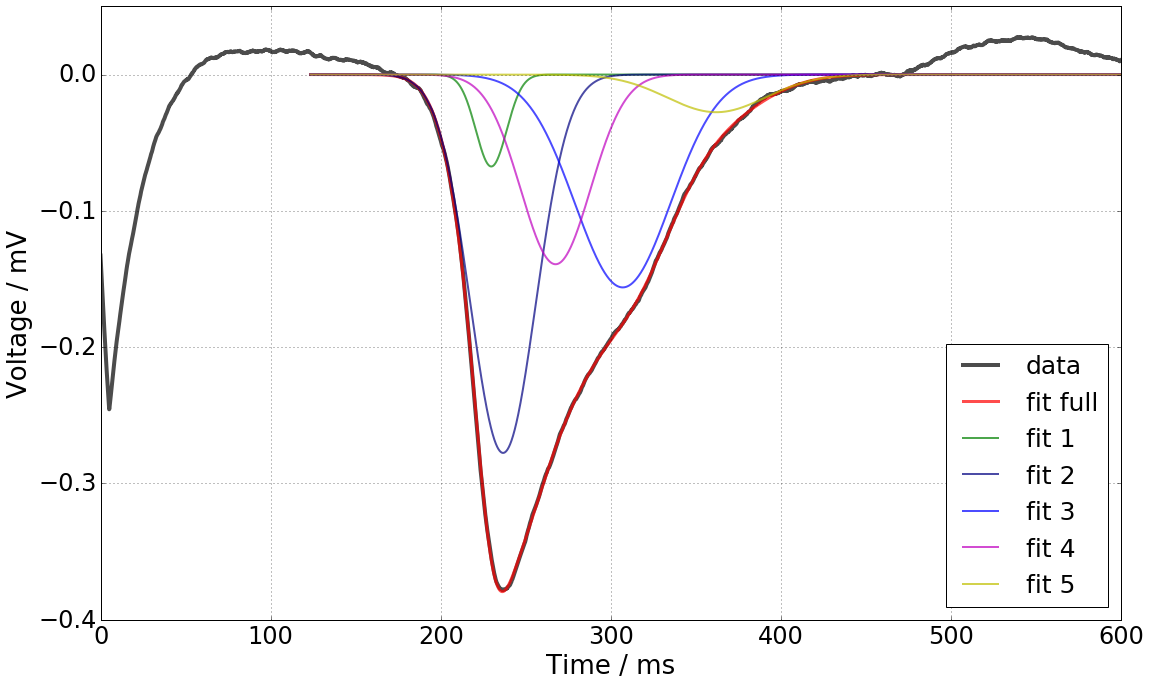

In [65]:
plt.figure(figsize=(15,9))

plt.plot(Xhot,Yhot,color='k',linewidth=4,alpha=0.7,label='data')
plt.plot(Xhot[CUT:],five_gaussians(Xhot[CUT:],*optim),'r',label='fit full',lw=3,alpha=0.7)


y1 = gaussian(Xhot[CUT:],*optim[0:3])
y2 = gaussian(Xhot[CUT:],*optim[3:6])
y3 = gaussian(Xhot[CUT:],*optim[6:9])
y4 = gaussian(Xhot[CUT:],*optim[9:12])
y5 = gaussian(Xhot[CUT:],*optim[12:15])

plt.plot(Xhot[CUT:],y1,'g',label='fit 1',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y2,'navy',label='fit 2',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y3,'b',label='fit 3',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y4,'m',label='fit 4',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y5,'y',label='fit 5',lw=2,alpha=0.7)


plt.xlim(0,600)
plt.ylim(-0.4,0.05)
plt.grid()
plt.legend(loc='lower right',fontsize=25)
plt.tight_layout()
plt.xlabel(r'Time / ms',fontsize=26)
plt.ylabel('Voltage / mV',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [66]:
chisquare(Yhot[CUT:], f_exp=five_gaussians(Xhot[CUT:],*optim))

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


Power_divergenceResult(statistic=-7.0396497923569049e+72, pvalue=1.0)

In [67]:
def six_gaussians(x, h1, c1, w1,
                      h2, c2, w2,
                      h3, c3, w3,
                      h4, c4, w4, 
                      h5, c5, w5,
                      h6, c6, w6):
    return (gaussian(x, h1, c1, w1) +
            gaussian(x, h2, c2, w2) +
            gaussian(x, h3, c3, w3) +
            gaussian(x, h4, c4, w4) +
            gaussian(x, h5, c5, w5) +
            gaussian(x, h6, c6, w6)) 

def gauss_fit_vals_6(X,Y):
    minn = min(Y)
    MeanLoc = np.where(Y==minn)[0][0]
    Mean = X[MeanLoc]
    g1 = [minn,Mean,20]
    g2 = [minn*.6,Mean+50,20]
    g3 = [minn*.3,Mean+75,20]
    g4 = [minn*.2,Mean+100,20]
    g5 = [minn*.1,Mean+125,20]
    g6 = [minn*.1,Mean+150,20]
    vals = g1+g2+g3+g4+g5+g6
    return vals

def SignalCut(X,Y):
    TriggerTime = find_nearest(Xhot,0)
    Trigger     = np.where(Xhot==TriggerTime)[0][0]
    Cut = Trigger+100
    minPulseHold = find_nearest(Yhot,min(Yhot[2*Cut:]))
    minPulse     = np.where(Yhot==minPulseHold)[0][0]
    SignalCut = Cut + (minPulse-Cut)/2
    return SignalCut


CUT = SignalCut(Xhot,Yhot)
fitval = gauss_fit_vals_6(Xhot[CUT:],Yhot[CUT:])

errfunc = lambda p, x, y: (six_gaussians(x, *p) - y)**2
optim, success = optimize.leastsq(errfunc, fitval, args=(Xhot[CUT:],Yhot[CUT:]))
optim

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:38: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:41: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


array([ -6.60121178e-02,   2.29595817e+02,   8.94161544e+00,
        -2.73991488e-01,   2.36921807e+02,   1.92990183e+01,
        -1.97827180e-01,   2.74458165e+02,   2.39108174e+01,
        -1.11917322e-01,   3.17237892e+02,   2.04847173e+01,
        -4.23599045e-02,   3.56748443e+02,   2.38138200e+01,
        -5.12461344e-03,   4.12978635e+02,   1.63447315e+01])

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning:

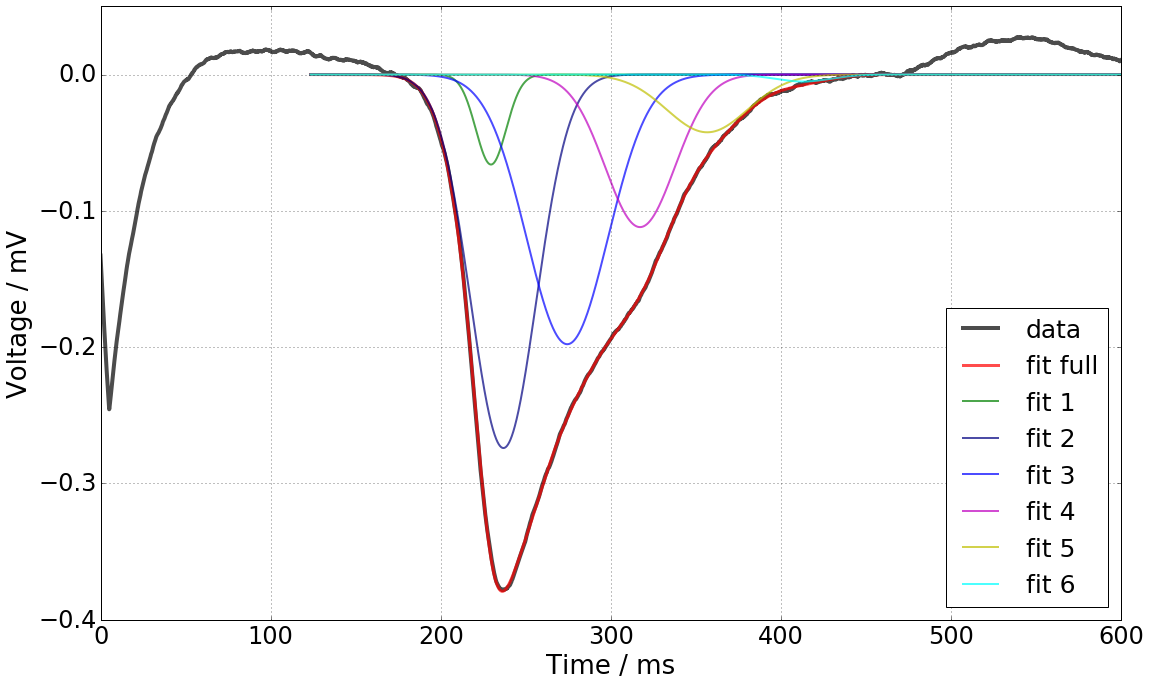

In [68]:
plt.figure(figsize=(15,9))

plt.plot(Xhot,Yhot,color='k',linewidth=4,alpha=0.7,label='data')
plt.plot(Xhot[CUT:],six_gaussians(Xhot[CUT:],*optim),'r',label='fit full',lw=3,alpha=0.7)


y1 = gaussian(Xhot[CUT:],*optim[0:3])
y2 = gaussian(Xhot[CUT:],*optim[3:6])
y3 = gaussian(Xhot[CUT:],*optim[6:9])
y4 = gaussian(Xhot[CUT:],*optim[9:12])
y5 = gaussian(Xhot[CUT:],*optim[12:15])
y6 = gaussian(Xhot[CUT:],*optim[15:18])


plt.plot(Xhot[CUT:],y1,'g',label='fit 1',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y2,'navy',label='fit 2',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y3,'b',label='fit 3',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y4,'m',label='fit 4',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y5,'y',label='fit 5',lw=2,alpha=0.7)
plt.plot(Xhot[CUT:],y6,'aqua',label='fit 6',lw=2,alpha=0.7)


plt.xlim(0,600)
plt.ylim(-0.4,0.05)
plt.grid()
plt.legend(loc='lower right',fontsize=25)
plt.tight_layout()
plt.xlabel(r'Time / ms',fontsize=26)
plt.ylabel('Voltage / mV',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [55]:
M=np.linspace(50,0,6,endpoint=True)

In [64]:
eh = []

for x in range(0,len(M)):
    print(M[x])
    eh+[M[x]]
eh

50.0
40.0
30.0
20.0
10.0
0.0


[]

In [9]:
def gaussian(x, height, center, width):
    return height*np.exp(-(x - center)**2/(2*width**2))

def SignalCut(X,Y):
    TriggerTime = find_nearest(Xhot,0)
    Trigger     = np.where(Xhot==TriggerTime)[0][0]
    Cut = Trigger+100
    minPulseHold = find_nearest(Yhot,min(Yhot[2*Cut:]))
    minPulse     = np.where(Yhot==minPulseHold)[0][0]
    SignalCut = Cut + (minPulse-Cut)/2
    return int(SignalCut)

def gauss_fit_vals_N(X,Y,N):
    minn    = min(Y)
    MeanLoc = np.where(Y==minn)[0][0]
    Mean    = X[MeanLoc]
    width   = 20
    Dmean   = np.linspace(0,150,N,endpoint=True)
    Dheight = np.linspace(1,0,N+1,endpoint=True)
    H = []
    W = []
    M = []
    for x in range(0,N):
        H.append(minn*Dheight[x])
        W.append(20)
        M.append(Mean+Dmean[x])
    FitVals = []
    boundsA  = []
    boundsB  = []
    for x in range(0,N):
        FitVals.append(H[x]) 
        FitVals.append(M[x])
        FitVals.append(W[x])
        boundsA.append(-1), boundsA.append(0), boundsA.append(0) 
        boundsB.append(0), boundsB.append(600), boundsB.append(100) 
        #bounds.append([(-1,0),(0,600),(10,100)])
    #return H, M, W
    return np.array(FitVals), (boundsA,boundsB)

def N_gaussians(x, VALS, N):
    func = np.zeros(len(x))
    fiting = np.reshape(VALS,(N,3))
    for q in range(0,N):
        func+=gaussian(x, fiting[q][0], fiting[q][1], fiting[q][2])
    
    return func



def Fit_N_gaussians(X,Y,N):
    CUT = SignalCut(X,Y)
    FitVals ,Bound = gauss_fit_vals_N(Xhot[CUT:],Yhot[CUT:],N)
    errfunc = lambda p, x, y: (N_gaussians(x, p, N) - y)**2
    pp = optimize.least_squares(errfunc, FitVals,bounds=Bound, args=(Xhot[CUT:],Yhot[CUT:]))
    return pp.x
    

In [7]:
def Chi(X,Y,N):
    Chi = []
    NN = list(range(1,N+1))
    for q in NN:
        OP = Fit_N_gaussians(X,Y,q)
        E = N_gaussians(X,OP,q)
        O = Y
        dof = len(O)-1-3*q
        chi = np.sum((O-E)**2/sigma**2)/dof
        Chi.append(chi)
    return Chi


In [330]:
CUT = SignalCut(Xhot,Yhot)
#Chi(Xhot[CUT:],Yhot[CUT:],3)
CH = Chi(Xhot,Yhot,15)

In [334]:
min(CH)
np.where(CH==min(CH))

(array([6]),)

(0, 10)

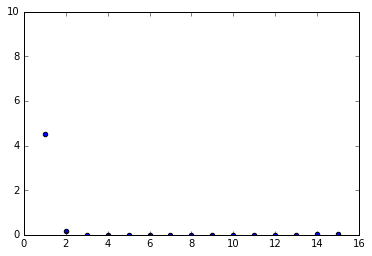

In [340]:
plt.scatter(list(range(1,15+1)),CH-CH[6])
plt.ylim(0,10)

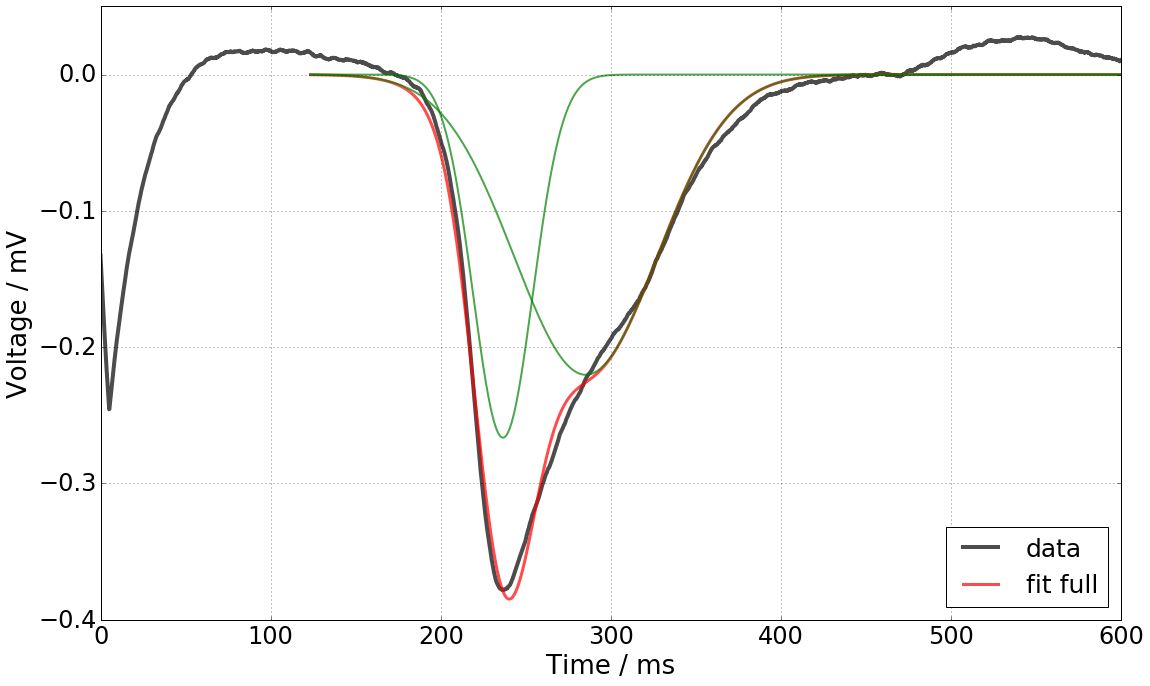

In [12]:
plt.figure(figsize=(15,9))
CUT = SignalCut(Xhot,Yhot)

aw = 2
plt.plot(Xhot,Yhot,color='k',linewidth=4,alpha=0.7,label='data')
OP = Fit_N_gaussians(Xhot,Yhot,aw)
OP = np.reshape(OP,(aw,3))
plt.plot(Xhot[CUT:],N_gaussians(Xhot[CUT:],OP,aw),'r',label='fit full',lw=3,alpha=0.7)

for q in range(0,aw):
    y1 = gaussian(Xhot[CUT:],*OP[q])
    plt.plot(Xhot[CUT:],y1,'g',lw=2,alpha=0.7)


plt.xlim(0,600)
plt.ylim(-0.4,0.05)
plt.grid()
plt.legend(loc='lower right',fontsize=25)
plt.tight_layout()
plt.xlabel(r'Time / ms',fontsize=26)
plt.ylabel('Voltage / mV',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [231]:
Fit_N_gaussians(Xhot[CUT:],Yhot[CUT:],3)

//anaconda/envs/py35/lib/python3.5/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 2000.
  warnings.warn(errors[info][0], RuntimeWarning)


array([  2.52002361e+04,   1.89996700e+04,   3.41354893e+03,
        -1.44449683e-01,   2.94727751e+02,   5.21338581e+01,
        -1.16266050e-02,   4.47445284e+02,   1.89650731e+01])

In [292]:
fit,bound = gauss_fit_vals_N(Xhot[CUT:],Yhot[CUT:],1)
bound

([-1, 0, 0], [0, 600, 100])

In [291]:
fittt , bound= gauss_fit_vals_N(Xhot[CUT:],Yhot[CUT:],1)
fittt

errfunc = lambda p, x, y: (N_gaussians(x, p, 1) - y)**2
optim, success = optimize.leastsq(errfunc, fittt, args=(Xhot[CUT:],Yhot[CUT:]))
optim

array([  -0.34622843,  257.92745244,   39.71646527])

In [280]:
fittt

array([  -0.37820625,  236.84999149,   20.        ])

In [284]:
([-1,0],[0,600],[10,100])
(np.inf,np.inf,np.inf)
([-1,0,0],[0,600,100])

([-1, 0, 0], [0, 600, 100])

In [293]:
pp = optimize.least_squares(errfunc, fittt,bounds=bound, args=(Xhot[CUT:],Yhot[CUT:]))
pp.x

array([  -0.34622955,  257.92766104,   39.71626901])

In [298]:
aw = 7
fittt , bound= gauss_fit_vals_N(Xhot[CUT:],Yhot[CUT:],aw)
fittt

errfunc = lambda p, x, y: (N_gaussians(x, p, aw) - y)**2
pp = optimize.least_squares(errfunc, fittt,bounds=bound, args=(Xhot[CUT:],Yhot[CUT:]))
pp.x

array([ -6.62236290e-02,   2.29608017e+02,   8.96161695e+00,
        -2.77412681e-01,   2.37021653e+02,   1.93236866e+01,
        -1.94196712e-01,   2.74169283e+02,   2.32834129e+01,
        -1.14551577e-01,   3.16176781e+02,   2.07056665e+01,
        -4.31912505e-02,   3.55548769e+02,   2.47560988e+01,
        -4.80408169e-03,   4.14123944e+02,   1.59684636e+01,
        -1.58562134e-04,   4.50343119e+02,   4.07416848e+00])

In [ ]:
bounds = [(),()]

In [237]:
OP
np.reshape(OP,(4,3))

array([[ -1.27174691e-01,   2.30095138e+02,   1.14095579e+01],
       [ -2.56910845e-01,   2.44910513e+02,   2.30974156e+01],
       [ -1.78021864e-01,   2.98075889e+02,   3.27965568e+01],
       [ -2.50601344e-02,   3.59819401e+02,   3.07418860e+01]])

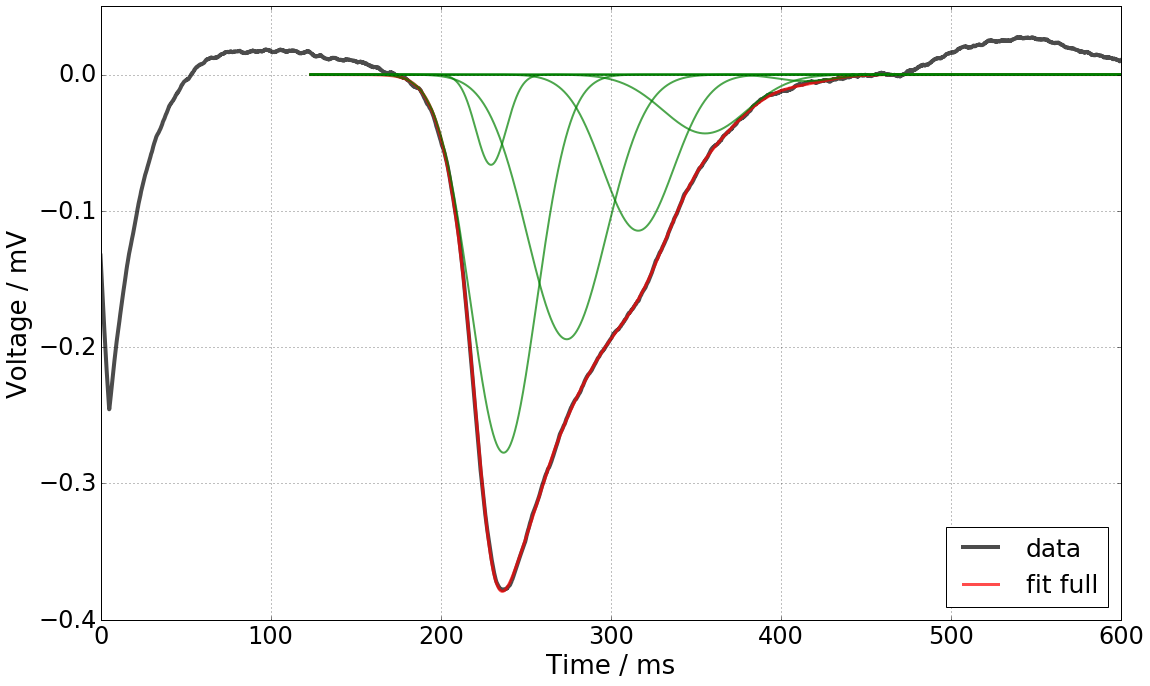

In [301]:
plt.figure(figsize=(15,9))
aw = 7
plt.plot(Xhot,Yhot,color='k',linewidth=4,alpha=0.7,label='data')
OP = Fit_N_gaussians(Xhot,Yhot,aw)
OP = np.reshape(OP,(aw,3))
plt.plot(Xhot[CUT:],N_gaussians(Xhot[CUT:],OP,aw),'r',label='fit full',lw=3,alpha=0.7)

for q in range(0,aw):
    y1 = gaussian(Xhot[CUT:],*OP[q])
    plt.plot(Xhot[CUT:],y1,'g',lw=2,alpha=0.7)


plt.xlim(0,600)
plt.ylim(-0.4,0.05)
plt.grid()
plt.legend(loc='lower right',fontsize=25)
plt.tight_layout()
plt.xlabel(r'Time / ms',fontsize=26)
plt.ylabel('Voltage / mV',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [ ]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def find_vals(X,Y,cut):
    dataX = X[cut:]
    dataY = Y[cut:]
    minn = min(dataY)
    sig_val = minn*0.5
    MeanLoc = np.where(dataY==minn)[0][0]
    Mean = dataX[MeanLoc]
    L = dataY[0:MeanLoc]
    R = dataY[MeanLoc:len(dataY)]
    LP =find_nearest(L,sig_val)
    RP =find_nearest(R,sig_val)
    whereL = np.where(L==LP)[0][0]
    whereR = np.where(R==RP)[0][0]
    Lpoint = dataX[whereL]
    Rpoint = dataX[MeanLoc+whereR]
    FWHM = (Rpoint-Lpoint)   
    return (Mean,FWHM)

def SignalCut(X,Y):
    TriggerTime = find_nearest(Xhot,0)
    Trigger     = np.where(Xhot==TriggerTime)[0][0]
    Cut = Trigger+100
    minPulseHold = find_nearest(Yhot,min(Yhot[2*Cut:]))
    minPulse     = np.where(Yhot==minPulseHold)[0][0]
    SignalCut = Cut + (minPulse-Cut)/2
    return int(SignalCut)

In [191]:
def Leading_vals(X,Y):
    cut = SignalCut(X,Y)
    dataX = X[cut:]
    dataY = Y[cut:]
    minn = min(dataY)
    MeanLoc = np.where(dataY==minn)[0][0]
    Mean = dataX[MeanLoc]
    start = find_nearest(dataX,Mean/2)
    StartLoc = np.where(dataX==start)[0][0]
    return StartLoc+cut , MeanLoc+cut
    

In [195]:
def gaussian(x, height, center, width):
    return height*np.exp(-(x - center)**2/(2*width**2))
def one_gaussians(x, h1, c1, w1):
    return (gaussian(x, h1, c1, w1))

def gauss_fit_vals(X,Y):
    minn = min(Y)
    MeanLoc = np.where(Y==minn)[0][0]
    Mean = X[MeanLoc]
    vals = [minn,Mean,20]
    return vals

def SignalCut(X,Y):
    TriggerTime = find_nearest(Xhot,0)
    Trigger     = np.where(Xhot==TriggerTime)[0][0]
    Cut = Trigger+100
    minPulseHold = find_nearest(Yhot,min(Yhot[2*Cut:]))
    minPulse     = np.where(Yhot==minPulseHold)[0][0]
    SignalCut = Cut + (minPulse-Cut)/2
    return int(SignalCut)

In [223]:
CUT = SignalCut(Xhot,Yhot)
fitval = gauss_fit_vals(Xhot[S:M],Yhot[S:M])

errfunc = lambda p, x, y: (gaussian(x, *p) - y)**2
optim, success = optimize.leastsq(errfunc, fitval, args=(Xhot[S:M],Yhot[S:M]))
optim

array([  -0.38447692,  237.27095904,   17.74987479])

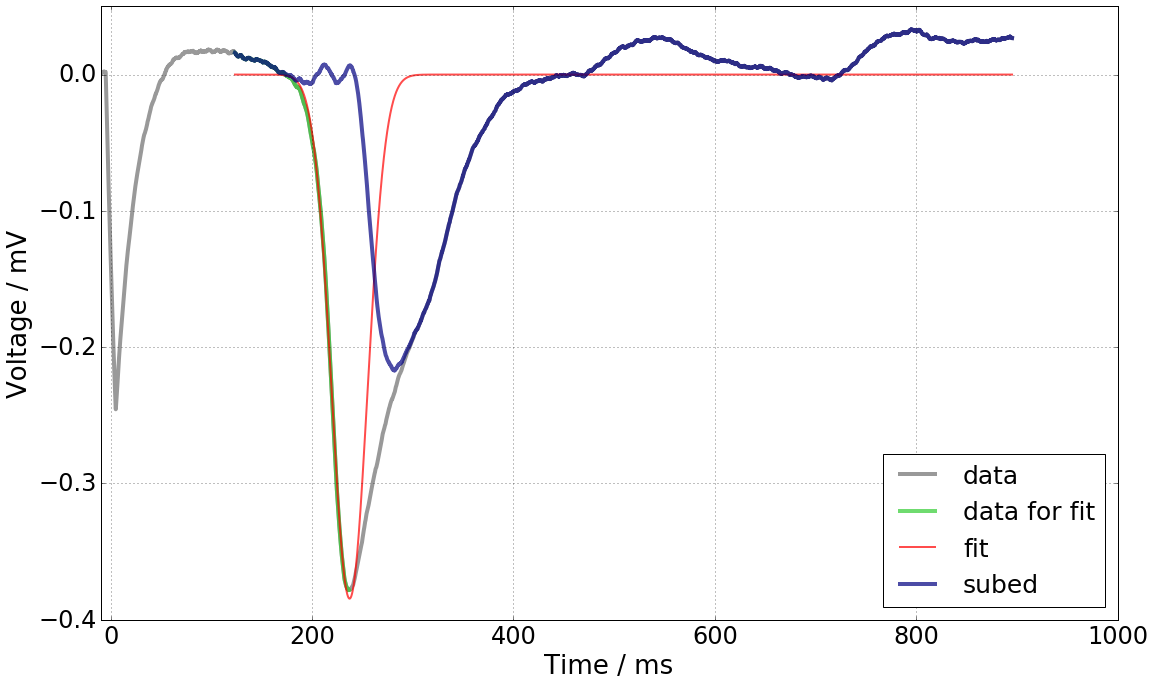

In [224]:
plt.figure(figsize=(15,9))

#plt.plot(Xhot,Yhot,color='k',linewidth=4,alpha=0.7,label='data')
S,M = Leading_vals(Xhot,Yhot)
plt.plot(Xhot,Yhot,color='k',linewidth=4,label='data',alpha=0.4)

plt.plot(Xhot[S:M],Yhot[S:M],color='limegreen',linewidth=4,alpha=0.7,label='data for fit')

plt.plot(Xhot[CUT:],gaussian(Xhot[CUT:],*optim),'r',label='fit',lw=2,alpha=0.7)

plt.plot(Xhot[CUT:],Yhot[CUT:] - gaussian(Xhot[CUT:],*optim),'navy',label='subed',lw=4,alpha=0.7)




#plt.plot(Xhot[CUT:],one_gaussians(Xhot[CUT:],*optim),'r',label='fit full',lw=3,alpha=0.7)
#y1 = gaussian(Xhot[CUT:],*optim[0:3])
#y2 = gaussian(Xhot[CUT:],*optim[3:6])
#plt.plot(Xhot[CUT:],y1,'g',label='fit 1',lw=2,alpha=0.7)
#plt.plot(Xhot[CUT:],y2,'g',label='fit 2',lw=2,alpha=0.7)

plt.xlim(-10,1000)
plt.ylim(-0.4,0.05)
plt.grid()
plt.legend(loc='lower right',fontsize=25)
plt.tight_layout()
plt.xlabel(r'Time / ms',fontsize=26)
plt.ylabel('Voltage / mV',fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()